![](img/330-banner.png)

# Lecture 13: Feature engineering and feature selection 

UBC 2020-21

Instructor: Varada Kolhatkar

## Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

## Learning outcomes 

From this lecture, students are expected to be able to:

- Explain what feature engineering is and the importance of feature engineering in building machine learning models.  
- Carry out preliminary feature engineering on text data. 
- Explain the general concept of feature selection. 
- Discuss and compare different feature selection methods at a high level. 
- Use `sklearn`'s implementation of recursive feature elimination (`RFE`) and forward and backward selection (`SequentialFeatureSelector`). 

## Announcements

- hw4 grades returned
- hw5 grading in progress
- Midterm grading in progress
- hw6 posted (Due on November 15th)
- hw7 will be posted next week Monday. (Likely to be due on November 15th. I'll try to make it shorter and fun! )
- Poll results so far:  

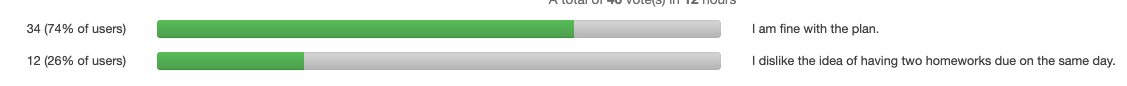

## Feature engineering: Motivation

### What is feature engineering?  

- Better features: more flexibility, higher score, we can get by with simple and more interpretable models. 
- If your features, i.e., representation is bad, whatever fancier model you build is not going to help.

<blockquote>
<b>Feature engineering</b> is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.<br> 
- Jason Brownlee    
</blockquote>    



### Some quotes on feature engineering 

A quote by Pedro Domingos [A Few Useful Things to Know About Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

<blockquote>
... At the end of the day, some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used. 
</blockquote>


A quote by Andrew Ng, [Machine Learning and AI via Brain simulations](https://ai.stanford.edu/~ang/slides/DeepLearning-Mar2013.pptx)

<blockquote>
Coming up with features is difficult, time-consuming, requires expert knowledge. "Applied machine learning" is basically feature engineering.
</blockquote>

### Better features usually help more than a better model.
- Good features would ideally:
    - capture most important aspects of the problem
    - allow learning with few examples 
    - generalize to new scenarios.

- There is a trade-off between simple and expressive features:
    - With simple features overfitting risk is low, but scores might be low.
    - With complicated features scores can be high, but so is overfitting risk.

### The best features may be dependent on the model you use.

- Examples:
    - For counting-based methods like decision trees separate relevant groups of variable values
        - Discretization makes sense 
    - For distance-based methods like KNN, we want different class labels to be "far".
        - Standardization 
    - For regression-based methods like linear regression, we want targets to have a linear dependency on features.

#### Domain-specific transformations

In some domains there are natural transformations to do:
- Spectrograms (sound data)
- Wavelets (image data)
- Convolutions 

![](img/spectogram.png)

<!-- <img src="img/spectogram.png" width="800" height="800"> -->

[Source](https://en.wikipedia.org/wiki/Spectrogram)

In this lecture, I'll show you two example domains where feature engineering plays an important role: 

- Text data 
- Audio data

<br><br><br><br>

## Common features used in text classification

### Bag of words 

- So far for text data we have been using bag of word features. 
- They are good enough for many tasks. But ... 
- This encoding throws out a lot of things we know about language
- It assumes that word order is not that important.   
- So if you want to improve the scores further on text classification tasks you carry out **feature engineering**. 

Let's look at some examples from research papers.  

### Example: Label "Personalized" Important E-mails: 
- [The Learning Behind Gmail Priority Inbox](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36955.pdf)
- Features: bag of words, trigrams, regular expressions, and so on.
- There might be some "globally" important messages:
    - "This is your mother, something terrible happened, give me a call ASAP."
- But your "important" message may be unimportant to others.
     - Similar for spam: "spam" for one user could be "not spam" for another.

- Social features (e.g., percentage of sender emails that is read by the recipient)
- Content features (e.g., recent terms the user has been using in emails)
- Thread features (e.g., whether the user has started the thread)
- ...

### [The Learning Behind Gmail Priority Inbox](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36955.pdf)

![](img/gmail_priority_inbox.png)

<!-- <img src="img/gmail_priority_inbox.png" width="1000" height="1000"> -->

#### Feature engineering examples: [Automatically Identifying Good Conversations Online](http://www.courtneynapoles.com/res/icwsm17-automatically.pdf)

![](img/classifying_good_conversations_online.png)

<!-- <img src="img/classifying_good_conversations_online.png" width="800" height="800"> -->


### (optional) Term weighing (TF-IDF) 

- A measure of relatedness between words and documents
- Intuition: Meaningful words may occur repeatedly in related documents, but functional words (e.g., _make_, _the_) may be distributed evenly over all documents


$$tf.idf(w_i,d_j) = (1+log(tf_{ij})) log\frac{D}{df_i}$$


where, 
- $tf_{ij}$ &rarr; number of occurrences of the term $w_i$ in document $d_j$
- $D$ &rarr; number of documents
- $df_i$ &rarr; number of documents in which $w_i$ occurs

Check `TfidfVectorizer` from `sklearn`. 

### N-grams 

- Incorporating more context 
- A contiguous sequence of _n_ items (characters, tokens) in text.
    <blockquote>
        CPSC330 students are hard-working .
    </blockquote>    

- 2-grams (bigrams): a contiguous sequence of two words
    * _CPSC330 students, students are, are hard-working, hard-working ._
- 3-grams (trigrams): a contiguous sequence of three words
    * _CPSC330 students are, students are hard-working, are hard-working ._

You can extract ngram features using `CountVectorizer` by passing `ngram_range`. 

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

X = [
    "URGENT!! As a valued network customer you have been selected to receive a $900 prize reward!",
    "Lol you are always so convincing.",
    "URGENT!! Call right away!!",
]
vec = CountVectorizer(ngram_range=(1, 3))
X_counts = vec.fit_transform(X)
bow_df = pd.DataFrame(X_counts.toarray(), columns=vec.get_feature_names(), index=X)

In [3]:
bow_df

,900,900 prize,900 prize reward,always,always so,always so convincing,are,are always,are always so,as,...,urgent call,urgent call right,valued,valued network,valued network customer,you,you are,you are always,you have,you have been
URGENT!! As a valued network customer you have been selected to receive a $900 prize reward!,1,1,1,0,0,0,0,0,0,1,...,0,0,1,1,1,1,0,0,1,1
Lol you are always so convincing.,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,1,1,1,0,0
URGENT!! Call right away!!,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


### ASIDE: [Google n-gram viewer](https://books.google.com/ngrams)
 
- All Our N-gram are Belong to You
    - https://ai.googleblog.com/2006/08/all-our-n-gram-are-belong-toyou.html

<blockquote>
Here at Google Research we have been using word n-gram models for a variety
of R&D projects, such as statistical machine translation, speech recognition,
spelling correction, entity detection, information extraction, and others.
That's why we decided to share this enormous dataset with everyone. We
processed 1,024,908,267,229 words of running text and are publishing the
counts for all 1,176,470,663 five-word sequences that appear at least 40
times. There are 13,588,391 unique words, after discarding words that appear
less than 200 times.”
</blockquote>

In [4]:
from IPython.display import HTML

url = "https://books.google.com/ngrams/"
HTML("<iframe src=%s width=1000 height=800></iframe>" % url)

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Aside: [Google n-gram viewer](https://books.google.com/ngrams)
 
- Count the occurrences of the bigram _smart women_ in the corpus from 1800 to 2000 

![](img/ngram_viewer_smart_woman.png)

<!-- <img src="img/ngram_viewer_smart_woman.png" width="800" height="800"> -->

### Aside: [Google n-gram viewer](https://books.google.com/ngrams)
 
- Trends in the word _challenge_ used as a noun vs. verb

![](img/ngram_viewer_challenge_NN_VB.png)

<!-- <img src="img/ngram_viewer_challenge_NN_VB.png" width="800" height="800"> -->

### Part-of-speech features

#### Part-of-speech (POS) in English

- Part-of-speech: A kind of syntactic category that tells you some of the grammatical properties of a word.
    * Noun &rarr; water, sun, cat  
    * Verb &rarr; run, eat, teach

    
<blockquote>
The ____ was running. 
</blockquote>    

- Only a noun fits here. 

### Part-of-speech (POS) features

- POS features use POS information for the words in text.  

<blockquote>
    CPSC330/<span style="color:green">PROPER_NOUN</span> students/<span style="color:green">NOUN</span> are/<span style="color:green">VERB</span> hard-working/<span style="color:green">ADJECTIVE</span>
</blockquote>    


### An example from a project 

- Data: a bunch of documents 
- Task: identify texts with *permissions* and identify who is giving permission to whom. 

<blockquote>
<b>You</b> may <b>disclose</b> Google confidential information when compelled to do so by law if <b>you</b> provide <b>us</b> reasonable prior notice, unless a court orders that <b>we</b> not receive notice.
</blockquote>

- A very simple solution
    * Look for pronouns and verbs. 
    * Add POS tags as features in your model. 
    * Maybe look up words similar to **disclose**.
    

### Penn Treebank part-of-speech tags (bonus)

![](img/PTB_POS.png)

<!-- <img src="img/PTB_POS.png" width="900" height="900"/> -->

- How do we extract part-of-speech information?
- We use **pre-trained models**! 

- A couple of popular libraries which include such pre-trained models. 
- `nltk`
```
conda install -c anaconda nltk 
```        
- spaCy
```
conda install -c conda-forge spacy
```

In [ ]:
import nltk

# nltk.download("punkt")

- You also need to download the language model which contains all the pre-trained models. For that run the following in your course `conda` environment. 

In [ ]:
#!python -m spacy download en_core_web_md

### [spaCy](https://spacy.io/) 

A useful package for text processing and feature extraction
- Active development: https://github.com/explosion/spaCy
- Interactive lessons by Ines Montani: https://course.spacy.io/en/
- Good documentation, easy to use, and customizable. 

In [5]:
import en_core_web_md  # pre-trained model
import spacy

nlp = en_core_web_md.load()

In [6]:
sample_text = """Dolly Parton is a gift to us all. 
From writing all-time great songs like “Jolene” and “I Will Always Love You”, 
to great performances in films like 9 to 5, to helping fund a COVID-19 vaccine, 
she’s given us so much. Now, Netflix bring us Dolly Parton’s Christmas on the Square, 
an original musical that stars Christine Baranski as a Scrooge-like landowner 
who threatens to evict an entire town on Christmas Eve to make room for a new mall. 
Directed and choreographed by the legendary Debbie Allen and counting Jennifer Lewis 
and Parton herself amongst its cast, Christmas on the Square seems like the perfect movie
to save Christmas 2020. 😻 👍🏿"""

# [Adapted from here.](https://thepopbreak.com/2020/11/22/dolly-partons-christmas-on-the-square-review-not-quite-a-christmas-miracle/)

Spacy extracts all interesting information from text with this call.

In [7]:
doc = nlp(sample_text)

Let's look at part-of-speech tags. 

In [8]:
print([(token, token.pos_) for token in doc][:20])

[(Dolly, 'PROPN'), (Parton, 'PROPN'), (is, 'AUX'), (a, 'DET'), (gift, 'NOUN'), (to, 'ADP'), (us, 'PRON'), (all, 'DET'), (., 'PUNCT'), (
, 'SPACE'), (From, 'ADP'), (writing, 'VERB'), (all, 'DET'), (-, 'PUNCT'), (time, 'NOUN'), (great, 'ADJ'), (songs, 'NOUN'), (like, 'ADP'), (“, 'PUNCT'), (Jolene, 'PROPN')]


- Often we want to know who did what to whom. 
- **Named entities** give you this information.  
- What are named entities in the text? 

In [9]:
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])
print("\nORG means: ", spacy.explain("ORG"))
print("\nPERSON means: ", spacy.explain("PERSON"))
print("\nDATE means: ", spacy.explain("DATE"))

Named entities:
 [('Dolly Parton', 'PERSON'), ('Jolene', 'PERSON'), ('9 to 5', 'CARDINAL'), ('COVID-19', 'ORG'), ('Netflix', 'ORG'), ('Dolly Parton’s', 'PERSON'), ('Christmas', 'DATE'), ('Christine Baranski', 'PERSON'), ('Christmas Eve', 'DATE'), ('Directed', 'ORG'), ('Debbie Allen', 'PERSON'), ('Jennifer Lewis', 'PERSON'), ('Parton', 'PERSON'), ('Christmas', 'DATE'), ('Christmas 2020', 'DATE')]

ORG means:  Companies, agencies, institutions, etc.

PERSON means:  People, including fictional

DATE means:  Absolute or relative dates or periods


In [10]:
from spacy import displacy

displacy.render(doc, style="ent")

###  An example from a project 

Goal: Extract and visualize inter-corporate relationships from disclosed annual 10-K reports of public companies. 

[Source for the text below.](https://www.bbc.com/news/business-39875417)

In [11]:
text = (
    "Heavy hitters, including Microsoft and Google, "
    "are competing for customers in cloud services with the likes of IBM and Salesforce."
)

In [12]:
doc = nlp(text)
displacy.render(doc, style="ent")
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])

Named entities:
 [('Microsoft', 'ORG'), ('Google', 'ORG'), ('IBM', 'ORG'), ('Salesforce', 'ORG')]


If you want emoji identification support install [`spacymoji`](https://pypi.org/project/spacymoji/) in the course environment. 

```
pip install spacymoji
```

After installing `spacymoji`, if it's still complaining about module not found, my guess is that you do not have `pip` installed in your `conda` environment. Go to your course `conda` environment install `pip` and install the `spacymoji` package in the environment using the `pip` you just installed in the current environment. 

```
conda install pip
YOUR_MINICONDA_PATH/miniconda3/envs/cpsc330/bin/pip install spacymoji
```

In [13]:
from spacymoji import Emoji

nlp.add_pipe("emoji", first=True);

Does the text have any emojis? If yes, extract the description. 

In [14]:
doc = nlp(sample_text)
doc._.emoji

[('😻', 138, 'smiling cat face with heart-eyes'),
 ('👍🏿', 139, 'thumbs up dark skin tone')]

### Final remarks

- If we want to go beyond bag-of-words and incorporate human knowledge in models, we carry out feature engineering. 
- Some common features include:
    - ngram features
    - part-of-speech features
    - named entity features
    - emoticons in text
- These are usually extracted from pre-trained models using libraries such as `spaCy`.  
- Now a lot of this has moved to deep learning.
- But industries still rely on manual feature engineering. 

<br><br>

## Classify music style from audio files

- Imagine you are asked to develop a music style classification system to help a song recommendation system. 
    - E.g., something similar to what Spotify does
- Training data: audio files along with their music styles (e.g., classical, blues, pop)
- Prediction task: Given a new raw audio file predict the music style of in the audio. 
- You can download the data from [MARSYAS](http://marsyas.info/downloads/datasets.html). 
    - Beware of the size; it is 1.2 GB.     

- We'll be using `librosa` library for feature engineering of audio files.  
- You can install `librosa` in your conda environment as follows: 

```
conda install -c conda-forge librosa
```

Text(0.5, 1.0, 'Monophonic')

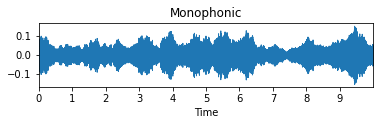

In [15]:
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load(
    "/Users/kvarada/MDS/data/genres/classical/classical.00001.au", duration=10
)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title("Monophonic")

In [16]:
import IPython.display

IPython.display.Audio(y, rate=sr)

- I have taken a subset of the above dataset with genres and stored it in `music_genres_small`
    - blues
    - classical
    - pop
    - rock


- Let's extract some domain-specific features called [MFCC features](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) from the above subset and store it as a CSV. I am pushing this CSV in the repo. 
- (You do not need to understand the feature extraction code below.)

In [17]:
data = {}
import glob
import ntpath

In [18]:
data_dir = "/Users/kvarada/MDS/data/music_genres_small/"
raw_audio_X = np.empty(shape=(400, 1))
raw_audio_y = []
row_ind = 0

for audio_file in glob.glob(data_dir + r"*/*.au"):
    y, sr = librosa.load(audio_file, mono=True, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    filename = ntpath.basename(audio_file)
    label = filename.split(".")[0]

    data.setdefault("audio_file", []).append(filename)
    data.setdefault("label", []).append(label)
    data.setdefault("chroma_stft", []).append(np.mean(chroma_stft))
    data.setdefault("spec_cent", []).append(np.mean(spec_cent))
    data.setdefault("spec_bw", []).append(np.mean(spec_bw))
    data.setdefault("rolloff", []).append(np.mean(rolloff))
    data.setdefault("zcr", []).append(np.mean(zcr))

    # Get mfcc features
    feat_prefix = "mfcc"
    ind = 1
    for feat in mfcc:
        key = feat_prefix + str(ind)
        data.setdefault(key, []).append(np.mean(feat))
        ind += 1
    try:
        raw_audio_X[row_ind] = np.mean(y)
        raw_audio_y.append(label)
    except:
        print("Broadcasting problem with file %s" % (audio_file))
    row_ind += 1

df = pd.DataFrame(data)
df.to_csv("data/music_genre.csv", index=False)

- If we just pass raw audio data to an ML model. 
- We are just taking the mean of the audio time series which won't be much meaningful in each case. 

In [19]:
raw_audio_y = np.asarray(raw_audio_y)
raw_audio_y.shape
X_train, X_test, y_train, y_test = train_test_split(
    raw_audio_X, raw_audio_y, test_size=0.20, random_state=111
)
lr = LogisticRegression(solver="liblinear")
pd.DataFrame(cross_validate(lr, X_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.005971,0.001022,0.250000,0.261719
1,0.001927,0.000430,0.250000,0.261719
2,0.001228,0.000374,0.265625,0.257812
3,0.001664,0.000480,0.265625,0.257812
4,0.002059,0.000699,0.265625,0.257812


Let's try it with standard domain-specific MFCC features.

In [20]:
music_cvs_df = pd.read_csv("data/music_genre.csv")
music_cvs_df.columns
X = music_cvs_df.drop(columns=["audio_file", "label"])
y = music_cvs_df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=111
)
lr = LogisticRegression(solver="liblinear")
pd.DataFrame(cross_validate(lr, X_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.021157,0.002793,0.781250,0.890625
1,0.016975,0.001959,0.859375,0.890625
2,0.015014,0.001803,0.781250,0.906250
3,0.011937,0.001329,0.734375,0.910156
4,0.011065,0.001183,0.796875,0.910156


- Much better results with domain-specific features!! 
- You could improve it further with more careful feature engineering. 

#### Summary

- Feature engineering is finding the useful representation of the data that can help us effectively solve our problem.  
- We looked at commonly used features in text data
    - Bag of word features 
    - N-gram features
    - Part-of-speech features
    - Classify music style from audio files
    

### Feature engineering 

- The best features are application-dependent.
- It's hard to give general advice. But here are some guidelines. 
    - Ask the domain experts.
    - Go through academic papers in the discipline. 
    - Often have idea of right discretization/standardization/transformation.
    - If no domain expert, cross-validation will help.
- If you have lots of data, use deep learning methods. 

<blockquote>
    The algorithms we used are very standard for Kagglers ... We spent most of our efforts in feature engineering... <br>
- Xavier Conort, on winning the Flight Quest challenge on Kaggle    
</blockquote>    

## Break (5 min)

![](img/eva-coffee.png)

<br><br><br><br>

## Feature selection: Introduction and motivation 


- With so many ways to add new features, we can increase dimensionality of the data. 
- More features means more complex models, which means increasing the chance of overfitting. 


### What is feature selection?

- Find the features	(columns) $X$ that are important for predicting	$y$, and remove the features that aren't. 

- Given $X = \begin{bmatrix}x_1 & x_2 & \dots & x_n\\  \\  \\  \end{bmatrix}$ and $y = \begin{bmatrix}\\  \\  \\  \end{bmatrix}$, find the columns $1 \leq j \leq n$ in $X$ that are important for predicting $y$.


### Why feature selection? 

- Interpretability: Models are more interpretable with fewer features. If you get the same performance with 10 features instead of 500 features, why not use the model with smaller number of features?     
- Computation: Models fit/predict faster with fewer columns.
- Data collection: What type of new data should I collect? It may be cheaper to collect fewer columns.
- Fundamental tradeoff: Can I reduce overfitting by removing useless features?

Feature selection can often result in better performing (less overfit), easier to understand, and faster model. 


### How do we carry out feature selection? 

- There are a number of ways. 
- You could use domain knowledge to discard features. 
- We are briefly going to look at two automatic feature selection methods from `sklearn`: 
    - Model-based selection 
    - Recursive feature elimination
    - Forward selection 
- Very related to looking at feature importances.

In [21]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
# rng = np.random.RandomState(42)
# noise = rng.normal(size=(len(cancer.data), 50)) # Let's add some random noise in `sklearn`'s breast cancer dataset.
# X_w_noise = np.hstack([cancer.data, noise])
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0, test_size=0.5
)

In [22]:
X_train.shape

(284, 30)

In [23]:
pipe_lr_all_feats = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe_lr_all_feats.fit(X_train, y_train)
pd.DataFrame(
    cross_validate(pipe_lr_all_feats, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.009641
score_time     0.000477
test_score     0.968233
train_score    0.987681
dtype: float64

### Model-based selection

- Use a supervised machine learning model to judge the importance of each feature.
- Keep only the most important once. 
- Supervised machine learning model used for feature selection can be different that the one used as the final estimator. 
- Use a model which has some way to calculate feature importances.

- To use model-based selection, we use `SelectFromModel` transformer.
- It selects features which have the feature importances greater than the provided threshold.
- Below I'm using `RandomForestClassifier` for feature selection with threahold "median" of feature importances. 
- Approximately how many features will be selected? 

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

select_rf = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42), threshold="median"
)

We can put the feature selection transformer in a pipeline. 

In [25]:
pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_rf, LogisticRegression(max_iter=1000)
)

pd.DataFrame(
    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.174698
score_time     0.018649
test_score     0.950564
train_score    0.974480
dtype: float64

In [26]:
pipe_lr_model_based.fit(X_train, y_train)
pipe_lr_model_based.named_steps["selectfrommodel"].transform(X_train).shape

(284, 15)

Similar results with only 15 features instead of 30 features. 

### Recursive feature elimination (RFE)

- Build a series of models
- At each iteration, discard the least important feature according to the model. 
- Computationally expensive
- Basic idea
    - fit model
    - find least important feature
    - remove
    - iterate.

### RFE algorithm 

1. Decide $k$, the number of features to select. 
2. Assign importances to features, e.g. by fitting a model and looking at `coef_` or `feature_importances_`.
3. Remove the least important feature.
4. Repeat steps 2-3 until only $k$ features are remaining.

Note that this is **not** the same as just removing all the less important features in one shot!

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [31]:
from sklearn.feature_selection import RFE

# create ranking of features
rfe = RFE(LogisticRegression(), n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)
rfe.ranking_

array([16, 12, 19, 13, 23, 20, 10,  1,  9, 22,  2, 25,  5,  7, 15,  4, 26,
       18, 21,  8,  1,  1,  1,  6, 14, 24,  3,  1, 17, 11])

In [32]:
print(rfe.support_)

[False False False False False False False  True False False False False
 False False False False False False False False  True  True  True False
 False False False  True False False]


In [33]:
print("selected features: ", cancer.feature_names[rfe.support_])

selected features:  ['mean concave points' 'worst radius' 'worst texture' 'worst perimeter'
 'worst concave points']


- How do we know what value to pass to `n_features_to_select`?

- Use `RFECV` which uses cross-validation to select number of features. 

In [35]:
from sklearn.feature_selection import RFECV

rfe_cv = RFECV(LogisticRegression(max_iter=2000), cv=10)
rfe_cv.fit(X_train_scaled, y_train)
print(rfe_cv.support_)
print(cancer.feature_names[rfe_cv.support_])

[False  True False  True False False  True  True  True False  True False
  True  True False  True False False False  True  True  True  True  True
 False False  True  True False  True]
['mean texture' 'mean area' 'mean concavity' 'mean concave points'
 'mean symmetry' 'radius error' 'perimeter error' 'area error'
 'compactness error' 'fractal dimension error' 'worst radius'
 'worst texture' 'worst perimeter' 'worst area' 'worst concavity'
 'worst concave points' 'worst fractal dimension']


In [36]:
rfe_pipe = make_pipeline(
    StandardScaler(),
    RFECV(LogisticRegression(max_iter=2000), cv=10),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

pd.DataFrame(cross_validate(rfe_pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       2.046847
score_time     0.011214
test_score     0.943609
train_score    1.000000
dtype: float64

- Slow because there is cross validation within cross validation 
- Not a big improvement in scores compared to all features on this toy case

<br><br>

### Search and score

- Define a **scoring function** $f(S)$ that measures the quality of the set of features $S$. 
- Now **search** for the set of features $S$ with the best score.

### General idea of search and score methods 

- Example: Suppose you have three features: $A, B, C$
    - Compute **score** for $S = \{\}$
    - Compute **score** for $S = \{A\}$
    - Compute **score** for $S= \{B\}$
    - Compute **score** for $S = \{C\}$
    - Compute **score** for $S = \{A,B\}$    
    - Compute **score** for $S = \{A,C\}$
    - Compute **score** for $S = \{B,C\}$
    - Compute **score** for $S = \{A,B,C\}$    
- Return $S$ with the best score.  
- How many distinct combinations we have to try out? 

### Forward or backward selection 

- Also called wrapper methods
- Shrink or grow feature set by removing or adding one feature at a time 
- Makes the decision based on whether adding/removing the feature improves the CV score or not

![](img/forward_selection.png)

<!-- <img src='img/forward_selection.png' width="1000" height="1000" /> -->

In [37]:
from sklearn.feature_selection import SequentialFeatureSelector

pipe_forward = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(LogisticRegression(max_iter=1000), direction="forward"),
    RandomForestClassifier(n_estimators=100, random_state=42),
)
pd.DataFrame(
    cross_validate(pipe_forward, X_train, y_train, return_train_score=True)
).mean()

fit_time       9.320900
score_time     0.011288
test_score     0.933020
train_score    1.000000
dtype: float64

In [39]:
pipe_forward = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(
        LogisticRegression(max_iter=1000), direction="backward", n_features_to_select=15
    ),
    RandomForestClassifier(n_estimators=100, random_state=42),
)
pd.DataFrame(
    cross_validate(pipe_forward, X_train, y_train, return_train_score=True)
).mean()

fit_time       11.832048
score_time      0.011730
test_score      0.950627
train_score     1.000000
dtype: float64

### Other ways to search 

- Stochastic local search
    - Inject randomness so that we can explore new parts of the search space
    - Simulated annealing
    - Genetic algorithms

### Warnings about feature selection 

- A feature's relevance is only defined in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- If features can be predicted from other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$ for the data you have.

### (Optional) Problems with feature selection 

- The term 'relevance' is not clearly defined.
- What all things can go wrong with feature selection?
- Attribution: From CPSC 340. 

#### Example: Is "Relevance" clearly defined?

- Consider a supervised classification task of predicting whether someone has particular genetic variation (SNP)

<img src='img/sex_mom_dad.png' width="600" height="600" />

- True model: You almost have the same value as your biological mom.

#### Is "Relevance" clearly defined?

- True model: You almost have the same value for SNP as your biological mom.
    - (SNP = biological mom) with very high probability 
    - (SNP != biological mom) with very low probability 
    

<img src='img/SNP.png' width="400" height="400"/>


#### Is "Relevance" clearly defined?

- What if "mom" feature is repeated?
- Should we pick both? Should we pick one of them because it predicts the other? 
- Dependence, collinearity for linear models
    - If a feature can be predicted from the other, don't know which one to pick. 

<img src='img/sex_mom_mom2_dad.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if we add (maternal) "grandma" feature?
- Is it relevant? 
    - We can predict SNP accurately using this feature
- Conditional independence
    - But grandma is irrelevant given biological mom feature
    - Relevant features may become irrelevant given other features

<img src='img/sex_mom_dad_grandma.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if we do not know biological mom feature and we just have grandma feature
- It becomes relevant now. 
    - Without mom feature this is the best we can do. 
- General problem ("taco Tuesday" problem)
    - Features can become relevant due to missing information 


<img src='img/sex_dad_grandma.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- Are there any relevant features now?
- They may have some common maternal ancestor.   
- What if mom likes dad because they share SNP? 
- General problem (Confounding)
    - Hidden features can make irrelevant features relevant.

<img src='img/sex_dad.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- Now what if we have "sibling" feature? 
- The feature is relevant in predicting SNP but not the cause of SNP. 
- General problem (non causality)
    - the relevant feature may not be causal 

<img src='img/sex_dad_sibling.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if you are given "baby" feature?
- Now the sex feature becomes relevant. 
    - "baby" feature is relevant when sex == F
    
- General problem (context specific relevance)
    - adding a feature can make an irrelevant feature relevant

<img src='img/sex_dad_baby.png' width="600" height="600"/>


#### Warnings about feature selection 

- A feature is only relevant in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- Confounding factors can make irrelevant features the most relevant.
- If features can be predicted from other other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 

- Is feature selection completely hopeless?
    - It is messy but we still need to do it. So we try to do our best! 

#### General advice on finding relevant features

- Try forward selection. 
- Try other feature selection methods (e.g., `RFE`, simulated annealing, genetic algorithms)
- Talk to domain experts; they probably have an idea why certain features are relevant.
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$.

#### Relevant resources 
- [Genome-wide association study](https://en.wikipedia.org/wiki/Genome-wide_association_study)
- [sklearn feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [PyData: A Practical Guide to Dimensionality Reduction Techniques](https://www.youtube.com/watch?v=ioXKxulmwVQ)

### True/False questions for class discussion 

1. Simple association-based feature selection approaches do not take into account the interaction between features.
2. You can carry out feature selection using linear models by pruning the features which have very small weights (i.e., coefficients less than a threshold).
3. Forward search is guaranteed to find the best feature set.  
4. The order of features removed given by `rfe.ranking_` is the same as the order of original feature importances given by the model.  